In [113]:
# Load lib
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,TensorDataset

In [114]:
# Load model
class net(nn.Module):

    def __init__(self):
        super().__init__()

        self.classi = nn.Sequential(
            nn.Linear(3,256),
            nn.ReLU(),
            nn.Linear(256,64),
            nn.Linear(64,1)
        )
    def forward(self,inputs):
        output = self.classi(inputs)

        return output

PATH = './triplet_network.pth'
model = net()
model.load_state_dict(torch.load(PATH, weights_only=True))
model.eval()
model.to('cuda')

net(
  (classi): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [115]:
folder = "75_dataset_nhit_abseta0_theta_s"
train_input = torch.load(f"data_eta_test/{folder}/data_train_input.csv",weights_only=False)
train_label = torch.load(f"data_eta_test/{folder}/data_train_label.csv",weights_only=False)
test_input = torch.load(f"data_eta_test/{folder}/data_test_input.csv",weights_only=False)
test_label = torch.load(f"data_eta_test/{folder}/data_test_label.csv",weights_only=False)
print(train_input.shape)
print(train_label.shape)
print(test_input.shape)
print(test_label.shape)

torch.Size([63482, 3])
torch.Size([63482, 2])
torch.Size([3500, 3])
torch.Size([3500, 2])


In [116]:
# Create dataloader
testset = TensorDataset(test_input,test_label)
test_data = DataLoader(
    dataset = testset,
    batch_size = test_input.shape[0],
    num_workers = 0,
    shuffle = False,
    pin_memory = True
)

In [117]:
for data in test_data:
    inputs,label = data
    inputs = inputs.to('cuda')
    results = model(inputs)

[[-18.48531 ]
 [-18.429062]
 [-18.431166]
 ...
 [-24.236635]
 [-24.132814]
 [-24.050034]]


(array([   7.,   31.,   35.,   34.,    2.,   18.,   52.,  902., 1891.,
          28.]),
 array([-19.5068531 , -19.3777523 , -19.2486515 , -19.11955261,
        -18.99045181, -18.86135101, -18.73225021, -18.60314941,
        -18.47405052, -18.34494972, -18.21584892]),
 <BarContainer object of 10 artists>)

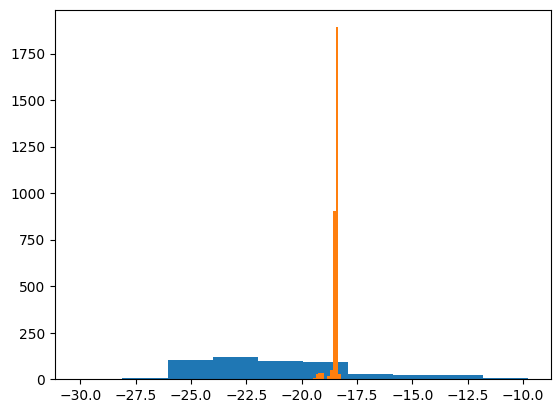

In [118]:
results = results.cpu().detach().numpy()
print(results)
plt.hist(results[3000:3500])
plt.hist(results[0:3000])

In [119]:
# Create reference dataloader
trainset = TensorDataset(train_input,train_label)
train_data = DataLoader(
    dataset = trainset,
    batch_size = train_input.shape[0],
    num_workers = 0,
    shuffle = False,
    pin_memory = True
)

In [120]:
for data in train_data:
    with torch.no_grad():
        inputs,label = data
        inputs = inputs.to('cuda')
        results_ref = model(inputs)
results_ref =results_ref.cpu().detach().numpy()
ref_citation = label[:,0]==1

tensor([ True,  True,  True,  ..., False, False, False])


(array([   52.,   506.,   616.,   356.,   208.,   528.,  1838., 28631.,
        21174.,   199.]),
 array([-19.55990219, -19.4177742 , -19.27564812, -19.13352013,
        -18.99139404, -18.84926605, -18.70713806, -18.56501198,
        -18.42288399, -18.2807579 , -18.13862991]),
 <BarContainer object of 10 artists>)

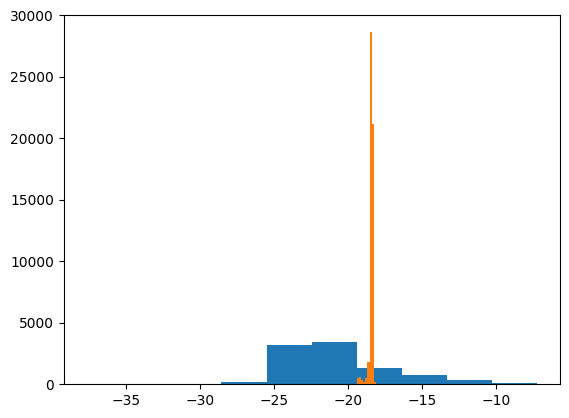

In [121]:
print(ref_citation)
plt.hist(results_ref[~ref_citation])
plt.hist(results_ref[ref_citation])


In [122]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
print(len(results_ref))
print(train_label.shape)
knn.fit(results_ref, train_label.cpu().numpy()) 


63482
torch.Size([63482, 2])


KNeighborsClassifier(n_neighbors=3)

In [ ]:
results_testing = []
index = 30000
for idx in range(test_input.shape[0]):
    embending_number = model(test_input[idx,:].to('cuda')).cpu().detach().numpy()
    #print(embending_number.reshape(-1,1))
    probs = knn.predict(embending_number.reshape(-1,1))
    #print(probs)
    results_testing.append(probs.reshape(2))
results_testing = torch.tensor(results_testing)
print(results_testing.shape)

result = results_testing[:,0] - results_testing[:,1]
#print(result.shape)
good_expected = result[0:index]
bad_expected = result[index:result.shape[0]]

accuracy_good = torch.sum(good_expected>0)
accuracy_bad = torch.sum(bad_expected<0)

print(accuracy_good/index)
print(accuracy_bad/(result.shape[0] - index))

torch.Size([3500, 2])
tensor(0.9957)
tensor(0.9400)
